### Week 06 - The generalized linear model ###

#### Reference: 

http://statsthinking21.org

* The general linear model
* Comparing means

### Multiple regression example: modeling aragonite saturation state


![images/arag_sat.png](images/arag_sat.png)

Source: Feeley et al. (2208) Evidence for upwelling of corrosive acidification water onto the continental shelf, Science

At Aragonite staturation state > 1 aragonite (calcium carbonate will dissolve in seawater)

Is there a way to estimate aragonite saturation state $\Omega_{Ar}$ based on more commonly measured parameters?

$$\Omega = \frac{[Ca^{2+}][CO_3^{2-}]}{K'_{sp}}$$

Where $K'_{sp}$ is the stoichiometric solubility product function of T,S,pr and mineral phase (aragonite, calcite)

$[Ca^{2+}]$  doesn't change much<br>
$[CO_3^{2+}]$ can be calculated from chemical measurements of DIC, $pCO_2$, total alkalinity and pH (at least two of these 4 parameters).

#### Models

Juranek et al. (2009) describe a set of least squares regression models for aragonite saturation state, based on more commonly measured oceangraphic variables (temperature, salinity, pressure, oxygen and nitrate).

Juranek, L. W., R. A. Feely, W. T. Peterson, S. R. Alin, B. Hales, K. Lee, C. L. Sabine, and J. Peterson, 2009: A novel method for determination of aragonite saturation state on the continental shelf of central Oregon using multi-parameter relationships with hydrographic data. Geophys. Res. Lett., 36, doi:10.1029/2009GL040778.

##### Model 1 

$$\Omega_{arag}^e = \beta_0 + \beta_1T + \beta_2S + \beta_3P + \beta_4O_2 + \beta_5NO_3^-$$

* Has high $R_a^2$ ("adjusted" $R^2$)
* High "variance inflation factor"
* Indicates multiple collinearity
* Coefficients are ambiguous and not meaningful - When you add more data, you get will get a different answer (this is bad!)

##### Adjusted $R^2$

Accounts for reduction of degrees of freedom when using multiple predictor variables.

$$R_a^2 = R^2 - (1-R^2)\frac{k}{n-k-1}$$

$$= 1 - \frac{MSE}{MST}$$

If the MSE is low, the adjusted R-squared is going to be high. The more observations you have, the less this adjustment matters.


##### Variance Inflation Factor

Variance Inflation Factor

$$VIF  = \frac{1}{1 - R^2}$$ 

where $R^2 $ from regression of predictor variables against other predictor variables. There is no clear "cut-off" that defines high VIF, but greater than 5 (and definitely greater than 10) is generally considered high.

![images/arag_sat_table.png](images/arag_sat_table.png)

##### Final Model

$$\Omega_{arag}^e = \alpha_0 + \alpha_1(O_2 - O_{2,r}) + \alpha_2(T - T_r) \times (O_2 - O_{2,r})$$

* Less variables, avoids multiple collinearity
* Includes interaction term
* Reference values ($T_r$ and $O_{2,r}$) keep product from getting too big
* Using variables with differing magnitudes can lead to problems like round-off errors
* Standardizing variables (using z-scores) another common strategy

![images/arag_sat_final.png](images/arag_sat_final.png)


__Aragonite saturation state__

_Red contours:_ from measured DIC and total alkalinaity

_Blue contours:_ Multiple regression model

__Application of the model to time series that do not have direct observations of the carbonate system parameters__

![images/arag_sat_ts.png](images/arag_sat_ts.png)


## Common statistical tests as linear models ##

Many statistical tests can be though of as implementations of the generalized linear model. Thinking of tests as part of a class of linear models can be more intuitive than thinking about how each test works individually.

### Resources

This approach is taken in Chapter 28 of *Statistical Thinking for the 21st Century* on comparing means:
* http://statsthinking21.org/comparing-means.html

A blog post by Jonas Kristoffer Lindeløv explains this approach for a wide array of statistical tests. Implementation of the statistical functions and linear models, with interpretations, are provided in both R and Python.
* Original post (using R): https://lindeloev.github.io/tests-as-linear/
* Python port: https://eigenfoo.xyz/tests-as-linear/

### Examples

The following examples show different ways of comparing means, using data from the 2007 West Coast Ocean Acidification cruise. The examples use quality controlled data from 0-10 dbar (upper 10m of the water column).

#### Comparing one sample mean to a single value

In this example the goal is to test whether the mean aragonite saturation state is different from a value of 1, a critical threshold for the ability of organisms to form calcium carbonate shells.

* $H_0$: $\bar{\Omega}_A =$ 1
* $H_A$: $\bar{\Omega}_A \neq$ 1 

The first step is to create a subset of good data from the upper 10m.

In [70]:
iisurf07 = ((df07['CTDPRS'] <= 10) &
      (df07['NITRAT_FLAG_W'] == 2) & (df07['PHSPHT_FLAG_W'] == 2)
      & (df07['CTDOXY_FLAG_W'] == 2) & (df07['CTDSAL_FLAG_W'] == 2) 
        & (df07['ALKALI_FLAG_W'] == 2) & (df07['TCARBN_FLAG_W'] == 2))

df07surf = df07[iisurf07]

A box plot is one way of showing the distribution of $\Omega_A$ values.
* Orange line: median, or 50th percentile
* Upper/lower limits on box: interquartile range, or 75th/25th percentiles
* Whiskers: each have length 1.5*interquartile range (pyplot default)
* Circles: extreme values
* Green triangle: mean
* Notches on box: 95% confidence intervals for median

Text(0.5, 1.0, '$\\Omega_A$ - upper 10m 2007')

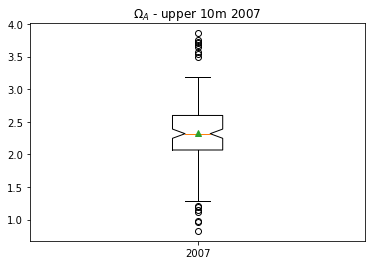

In [71]:
plt.figure()
plt.boxplot(np.array(df07['OmegaA'][iisurf07]),labels=['2007'],showmeans=True,notch=True);
plt.title('$\Omega_A$ - upper 10m 2007')

##### Method 1: one sample t-test

A one-sample t-test can be used to test whether the null hypothesis can be rejected at the 95% confidence level ($\alpha$ = 0.05). 

In [72]:
stats.ttest_1samp(np.array(df07surf['OmegaA']),popmean=1)

Ttest_1sampResult(statistic=28.43230570935999, pvalue=2.5238884999372847e-59)

##### Method 2: generalized linear model

Alternatively, this test can be framed in terms of a general linear model

$$ \hat{y} = \hat{a}_1 + \hat{a}_2 x ,$$

In this application, $y$ represents the $\Omega_A$ data. There is only one group, so we can set $x = 0$ for all values, making the slope parameter $\hat{a}_2$ irrelevant. The model then reduces to

$$ \hat{y} = \hat{a}_1 ,$$

or a model for the intercept parameter only. This equation can also be expressed as

$$ \hat{y} = \hat{a}_1 \times 1.$$

This model for the data in terms of a constant intercept can be implemented with the `statsmodels` library:

In [73]:
res = smf.ols(formula="OmegaA ~ 1", data=df07surf).fit()

The summary of the results shows that the intercept is 2.33, which is also the mean of the data. The 95% confidence intervals do not overlap with 1, which means that the null hypothesis can be rejected at $\alpha$ = 0.05. This approach to hypothesis testing will give the same results as the one sample t-test for $N$ > 14.

Notice that the test statistic $t$ is different from the one sample t-test. This is because `statsmodels` automatically tests whether parameters are different from *zero*, while in this case we are interested in whether the mean/intercept is different from *one*.

In [74]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 OmegaA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 10 Mar 2020   Prob (F-statistic):                nan
Time:                        16:40:13   Log-Likelihood:                -112.79
No. Observations:                 138   AIC:                             227.6
Df Residuals:                     137   BIC:                             230.5
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3309      0.047     49.795      0.000       2.238       2.423
==============================================================================
Omnibus:                        7.528   Durbin-Watson:                   0.666
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               12.146
Skew:                           0.195   Prob(JB):                      0.00230
Kurtosis:                       4.400   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comparing two sample means

We can also apply the generalized linear model approach when comparing two means. In this case, we will examine whether there is a statistically significant difference between the mean of $\Omega_A$ to the north and south of Cape Mendocino. At a latitude of 40.4$^o$N, Cape Mendocino represents a sharp transition point in many oceanographic processes and water masses.

The first steps are to make two subsets based on latitude, and then visualize the results in a box plot.

In [75]:
# create a new boolean variable in the df07surf dataframe
df07surf = df07[iisurf07]
df07surf = df07surf.assign(is_northern = df07surf['LATITUDE'] > 40.4);

iinorth = np.array(df07surf.is_northern == True)
iisouth = np.array(df07surf.is_northern == False)

Text(0.5, 1.0, '$\\Omega_A$ - upper 10m 2007')

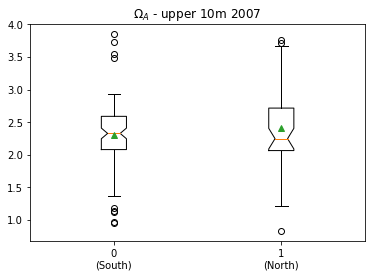

In [76]:
plt.figure()
plt.boxplot([df07surf['OmegaA'][iisouth],df07surf['OmegaA'][iinorth]],
            labels=['0\n(South)','1\n(North)'],showmeans=True,notch=True)
plt.title('$\Omega_A$ - upper 10m 2007')

##### Method 1: t-test

There is a difference of 0.104 in the mean of $\Omega_A$ between the two regions.

In [77]:
np.mean(df07surf['OmegaA'][iinorth]) - np.mean(df07surf['OmegaA'][iisouth])

0.10427563391405359

Is this difference statistically significant? A Student's t-test can be used to test whether the null hypothesis of no difference can be rejected at the 95% confidence level. 

In [78]:
stats.ttest_ind(df07surf['OmegaA'][iinorth],df07surf['OmegaA'][iisouth],equal_var=True)

Ttest_indResult(statistic=1.0251798309255598, pvalue=0.30709834696023874)

A Welch's t-test relaxes the assumption of equal variance.

In [79]:
stats.ttest_ind(df07surf['OmegaA'][iinorth],df07surf['OmegaA'][iisouth],equal_var=False)

Ttest_indResult(statistic=0.9223324103895281, pvalue=0.35989367953568807)

##### Method 2: generalized linear model

This test can also be framed in terms of a general linear model

$$ \hat{y} = \hat{a}_1 + \hat{a}_2 x .$$

Again, $\hat{y}$ is a model for the aragonite saturation state data. In this case, we can think of the southern data points as having $x = 0$ and the northern data points as having $x = 1$.

In this model, the intercept parameter $\hat{a}_1$ is the mean of the points with $x = 0$, the southern points.

The slope parameter $\hat{a}_2$ is equal to the difference between the means of the two groups.

$$ slope = \frac{\Delta\bar{y}}{\Delta x} = \frac{\Delta\bar{y}}{1} = \Delta\bar{y}$$ 

In [80]:
res = smf.ols(formula="OmegaA ~ is_northern", data=df07surf).fit()

The results are summarized below. The slope parameter $\hat{a}_2$ in our model is the coefficient for the `is_northern` variable. This is a Boolean variable that is equal to 0 (`False`) for southern points and 1 (`True`) for northern points. Notice that this coefficient is equal to 0.104, which the same as the difference between the two means.

Also notice that the 95% confidence intervals (shown as the `[0.025 0.975]` interval) overlap 0 for this parameter. This means that the difference is not statistically significant at the 95% confidence ($\alpha$ = 0.05) level. This summary also shows a t-statistic and p-value for this parameter, which are equivalent to the Student's t-test result shown above.

In [81]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 OmegaA   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.051
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.307
Time:                        16:40:16   Log-Likelihood:                -112.25
No. Observations:                 138   AIC:                             228.5
Df Residuals:                     136   BIC:                             234.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.2992      0.056     40.974      0.000       2.188       2.410
is_northern[T.True]     0.1043      0.102      1.025      0.307      -0.097       0.305
==============================================================================
Omnibus:                        6.623   Durbin-Watson:                   0.673
Prob(Omnibus):                  0.036   Jarque-Bera (JB):               10.616
Skew:                           0.126   Prob(JB):                      0.00495
Kurtosis:                       4.335   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comparing two sample means (another example)

The following shows the same calculations for temperature. In this case, the null hypothesis can be rejected at the 95% confidence level, and the 95% confidence intervals for the model slope do *not* overlap with zero.

Text(0.5, 1.0, 'CTDTMP - upper 10m 2007')

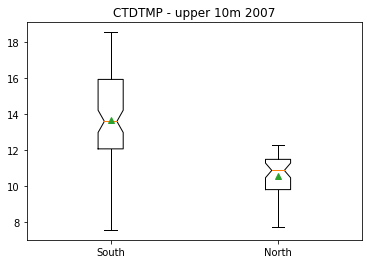

In [82]:
plt.figure()
plt.boxplot([df07surf['CTDTMP'][iisouth],df07surf['CTDTMP'][iinorth]],
            labels=['South','North'],showmeans=True,notch=True);
plt.title('CTDTMP - upper 10m 2007')

In [83]:
stats.ttest_ind(df07surf['CTDTMP'][iinorth],df07surf['CTDTMP'][iisouth],equal_var=True)

Ttest_indResult(statistic=-7.3756898407987945, pvalue=1.4522086213500461e-11)

In [84]:
stats.ttest_ind(df07surf['CTDTMP'][iinorth],df07surf['CTDTMP'][iisouth],equal_var=False)

Ttest_indResult(statistic=-9.799130523807381, pvalue=1.7823812194777806e-17)

In [85]:
res = smf.ols(formula="CTDTMP ~ is_northern", data=df07surf).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CTDTMP   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     54.40
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           1.45e-11
Time:                        16:40:18   Log-Likelihood:                -310.63
No. Observations:                 138   AIC:                             625.3
Df Residuals:                     136   BIC:                             631.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.6931      0.236     57.959      0.000      13.226      14.160
is_northern[T.True]    -3.1587      0.428     -7.376      0.000      -4.006      -2.312
==============================================================================
Omnibus:                        4.510   Durbin-Watson:                   0.191
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.064
Skew:                          -0.408   Prob(JB):                        0.131
Kurtosis:                       3.202   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""